In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", torch_dtype="auto", device_map="auto")
model.eval()
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
def shannon_entropy(px, dim=None, keepdim=False):
    if isinstance(px, np.ndarray):
        px = torch.from_numpy(px)
    
    # Avoid log(0) by adding small epsilon where px is 0
    eps = 1e-10
    eps_tensor = torch.tensor(eps, device=px.device, dtype=px.dtype)
    px_safe = torch.where(px > 0, px, eps_tensor)
    
    # Calculate Shannon entropy: -sum(p(x) * log2(p(x)))
    log_px = torch.log2(px_safe)
    entropy_terms = px * log_px
    
    # Only include terms where px > 0 (set others to 0)
    zero_tensor = torch.tensor(0.0, device=px.device, dtype=px.dtype)
    entropy_terms = torch.where(px > 0, entropy_terms, zero_tensor)
    
    # Sum along specified dimension
    entropy = -torch.mean(entropy_terms, dim=dim, keepdim=keepdim)
    
    return entropy

In [3]:
model_inputs = tokenizer(["Hi, my name IZ"], return_tensors="pt").to("cuda")
generated_ids = model(**model_inputs, output_attentions=True, output_hidden_states=True)
lm_head = model.lm_head
norm = model.model.norm

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [4]:
batch_index = 0
attention_entropy = None
attention_entropy_bar = None

proxy_attn_entropy = None
proxy_dot_prod = None
hidden_state_cos = None
hidden_state_dis = None

predicted_tokens = []

logit_entropy_per_layer = []
# # Calculate entropy for each attention head in the first layer
for layer_idx in range(len(generated_ids.attentions)):
    # (heads, seq_len, seq_len)
    attention_matrix = (
        generated_ids.attentions[layer_idx][batch_index].cpu().detach().numpy()
    )
    hs = generated_ids.hidden_states[layer_idx].to(torch.float32)
    hs1 = generated_ids.hidden_states[layer_idx+1].to(torch.float32)
    
  
    hidden_state_cos_step = F.cosine_similarity(
        hs1,
        hs,
        dim=-1,
    )
    hidden_state_dis_step = torch.linalg.norm(
        hs1
        - hs,
        dim=-1,
    )

    # dim -1, shape (heads, seq_len)
    entropy_per_row = shannon_entropy(attention_matrix, dim=-1).mean(dim=0).unsqueeze(0)
    entropy_per_row_bar = torch.concatenate((torch.tensor([0]),shannon_entropy(attention_matrix[:,1:,1:], dim=-1).mean(dim=0))).unsqueeze(0)
    

    # dim -1, shape (seq_len, seq_len)
    dot_prod = F.softmax(torch.einsum(
            "ijk,igh->ijg",
            hs1[:,1:,:],
            hs1[:,1:,:])/32, dim=-1)
    # x_shifted = dot_prod - dot_prod.min(dim=-1, keepdim=True)[0]
    # dot_prod = x_shifted / (x_shifted.sum(dim=-1, keepdim=True) + 1e-12)

    attn_proxy = shannon_entropy(dot_prod, dim=-1)
    hidden_state = hs1[:, :, :].unsqueeze(
        1
    ) 
    logits = lm_head(
        norm(generated_ids.hidden_states[layer_idx+1]) if layer_idx < 31 else generated_ids.hidden_states[layer_idx+1]
    ).to(torch.float32)  # Shape: [batch, 1, vocab_size]
    # Get predicted token

    predicted_token_id = torch.argmax(logits, dim=-1)
    predicted_token = [tokenizer.decode([i]) for i in predicted_token_id[0]]
    predicted_tokens.append(predicted_token)

    probs = torch.softmax(logits, dim=-1).squeeze((0, 1))
    entropy = -(probs * torch.log2(probs + 6e-8)).sum(dim=-1)
    logit_entropy_per_layer.append(entropy.detach().cpu().numpy())

    if attention_entropy is None:
        attention_entropy = entropy_per_row
        attention_entropy_bar = entropy_per_row_bar
        hidden_state_cos = hidden_state_cos_step
        hidden_state_dis = hidden_state_dis_step
        proxy_attn_entropy = attn_proxy
        proxy_dot_prod = dot_prod

    else:
        attention_entropy = torch.cat((attention_entropy, entropy_per_row))
        attention_entropy_bar = torch.cat((attention_entropy_bar, entropy_per_row_bar))
        hidden_state_cos = torch.cat((hidden_state_cos, hidden_state_cos_step))
        hidden_state_dis = torch.cat((hidden_state_dis, hidden_state_dis_step/layer_idx))
        proxy_attn_entropy = torch.cat((proxy_attn_entropy, attn_proxy))
        proxy_dot_prod = torch.cat((proxy_dot_prod, dot_prod))


proxy_attn_entropy= proxy_attn_entropy.detach().cpu().numpy()
hidden_state_dis= hidden_state_dis.detach().cpu().numpy()
hidden_state_cos= hidden_state_cos.detach().cpu().numpy()

proxy_dot_prod= proxy_dot_prod.detach().cpu().numpy()

/tmp/ipykernel_401630/3898734925.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  zero_intercepts = np.where(np.abs(attention_entropy_values) <= tau)[0]


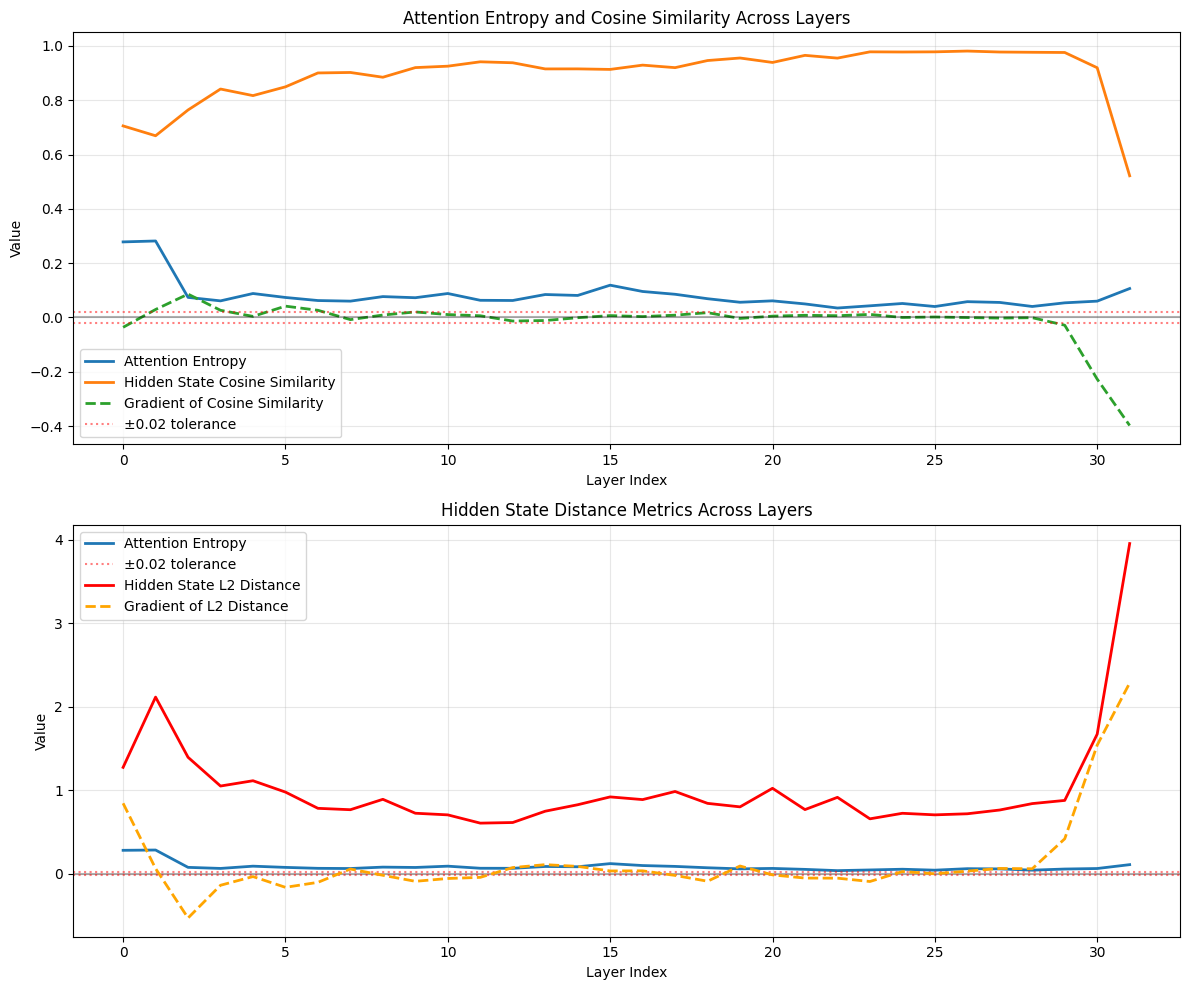

No zero intercepts found within tolerance τ=0.02


In [31]:
# Create subplots for better organization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
token_id = 4
tau = 0.02  # Tolerance for zero intercept detection

# Plot attention entropy and cosine similarity metrics
attention_entropy_values = attention_entropy[:,token_id]
ax1.plot(attention_entropy_values, label='Attention Entropy', linewidth=2)
ax1.plot(hidden_state_cos[:,token_id], label='Hidden State Cosine Similarity', linewidth=2)
ax1.plot(np.gradient(hidden_state_cos[:,token_id]), label='Gradient of Cosine Similarity', linewidth=2, linestyle='--')

# Find zero intercepts within tolerance
zero_intercepts = np.where(np.abs(attention_entropy_values) <= tau)[0]
if len(zero_intercepts) > 0:
    ax1.scatter(zero_intercepts, attention_entropy_values[zero_intercepts], 
               color='red', s=100, zorder=5, label=f'Zero intercepts (τ={tau})')
    ax2.scatter(zero_intercepts, attention_entropy_values[zero_intercepts], 
               color='red', s=100, zorder=5, label=f'Zero intercepts (τ={tau})')
    for idx in zero_intercepts:
        ax1.annotate(f'Layer {idx}', (idx, attention_entropy_values[idx]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
        ax2.annotate(f'Layer {idx}', (idx, attention_entropy_values[idx]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.axhline(y=tau, color='red', linestyle=':', alpha=0.5, label=f'±{tau} tolerance')
ax1.axhline(y=-tau, color='red', linestyle=':', alpha=0.5)
ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Value')
ax1.set_title('Attention Entropy and Cosine Similarity Across Layers')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot distance metrics
ax2.plot(attention_entropy[:,token_id], label='Attention Entropy', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(y=tau, color='red', linestyle=':', alpha=0.5, label=f'±{tau} tolerance')
ax2.axhline(y=-tau, color='red', linestyle=':', alpha=0.5)
ax2.plot(hidden_state_dis[:,token_id], label='Hidden State L2 Distance', linewidth=2, color='red')
ax2.plot(np.gradient(hidden_state_dis[:,token_id]), label='Gradient of L2 Distance', linewidth=2, linestyle='--', color='orange')
ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Value')
ax2.set_title('Hidden State Distance Metrics Across Layers')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print zero intercept information
if len(zero_intercepts) > 0:
    print(f"Zero intercepts found at layers: {zero_intercepts}")
    print(f"Values at intercepts: {attention_entropy_values[zero_intercepts]}")
else:
    print(f"No zero intercepts found within tolerance τ={tau}")

/tmp/ipykernel_401630/494896693.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(


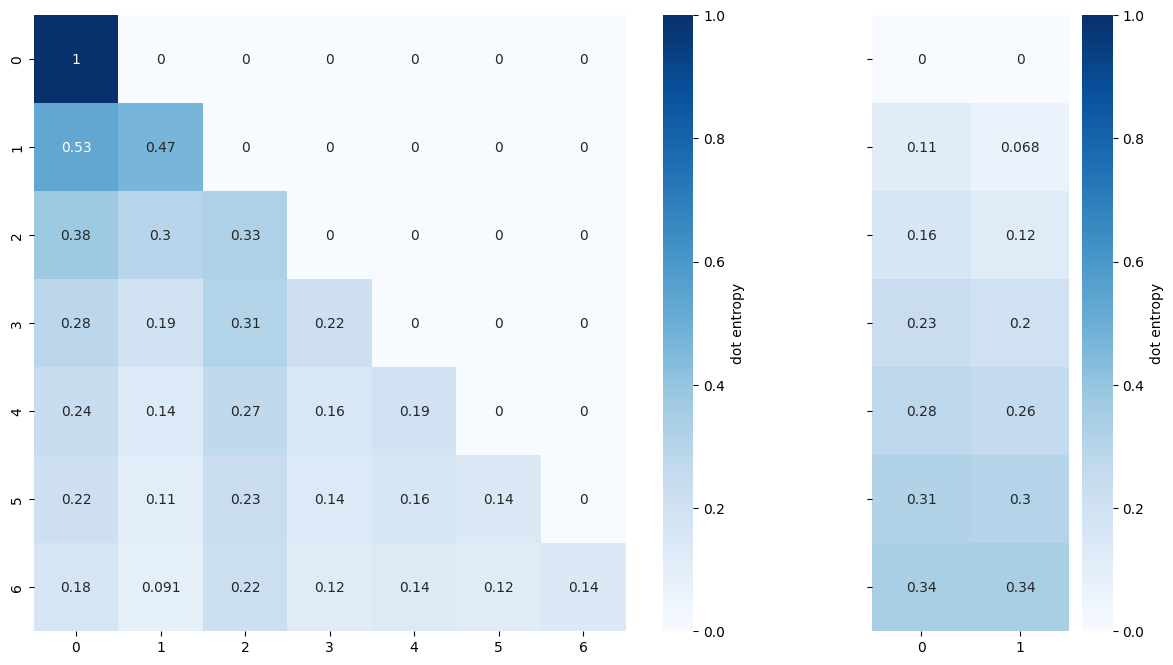

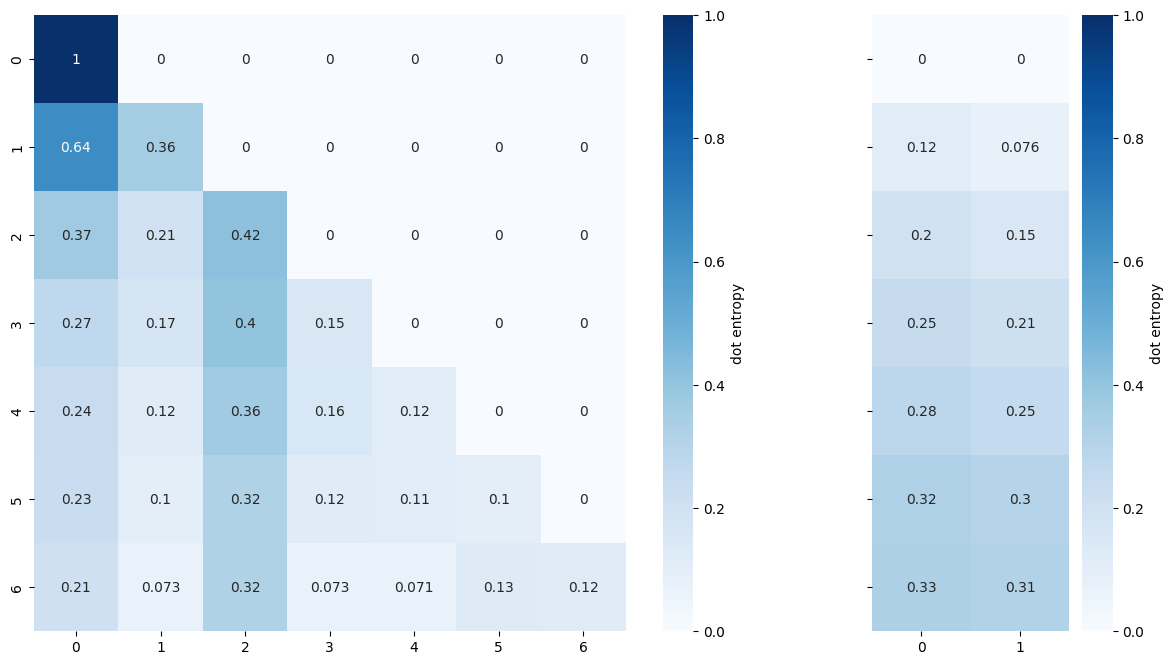

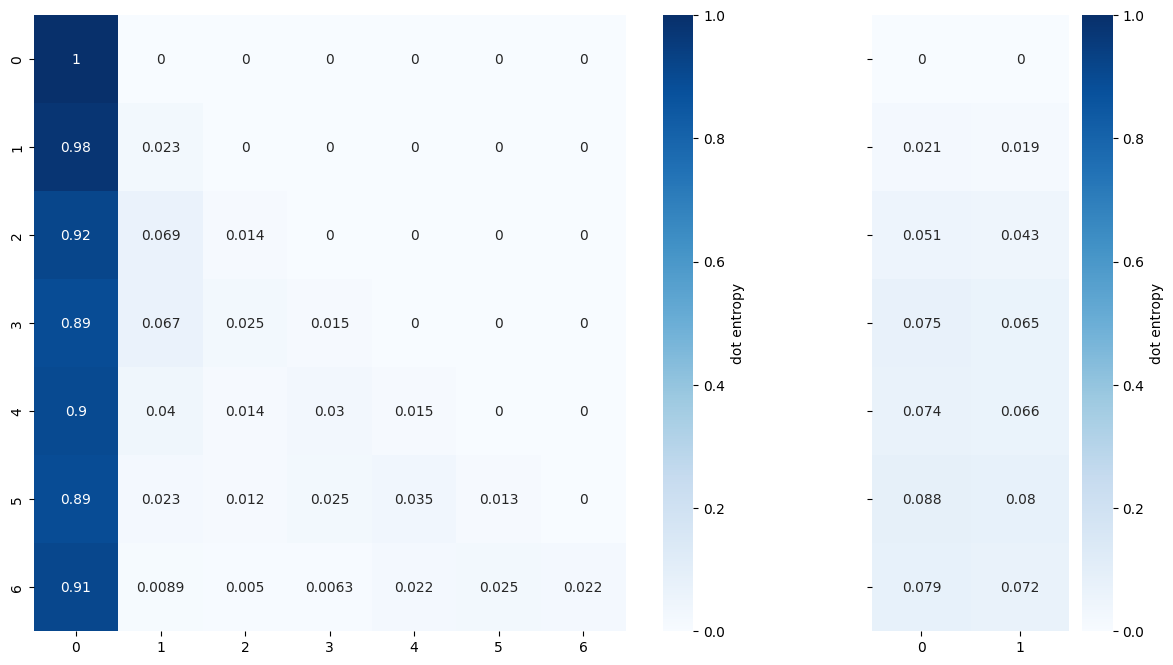

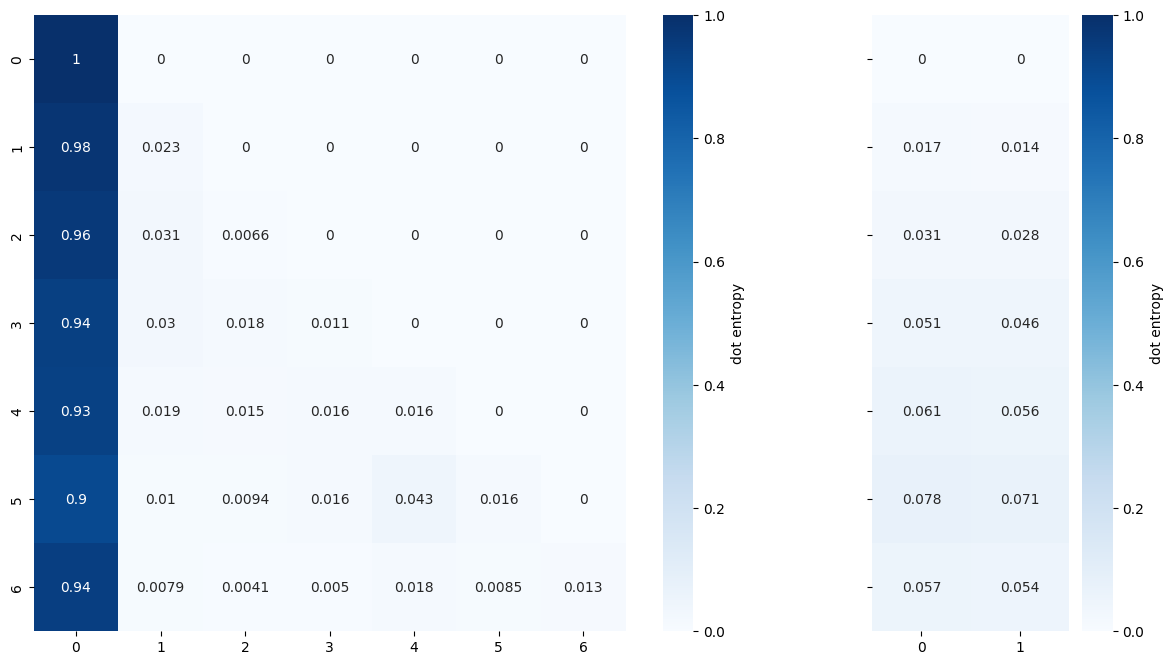

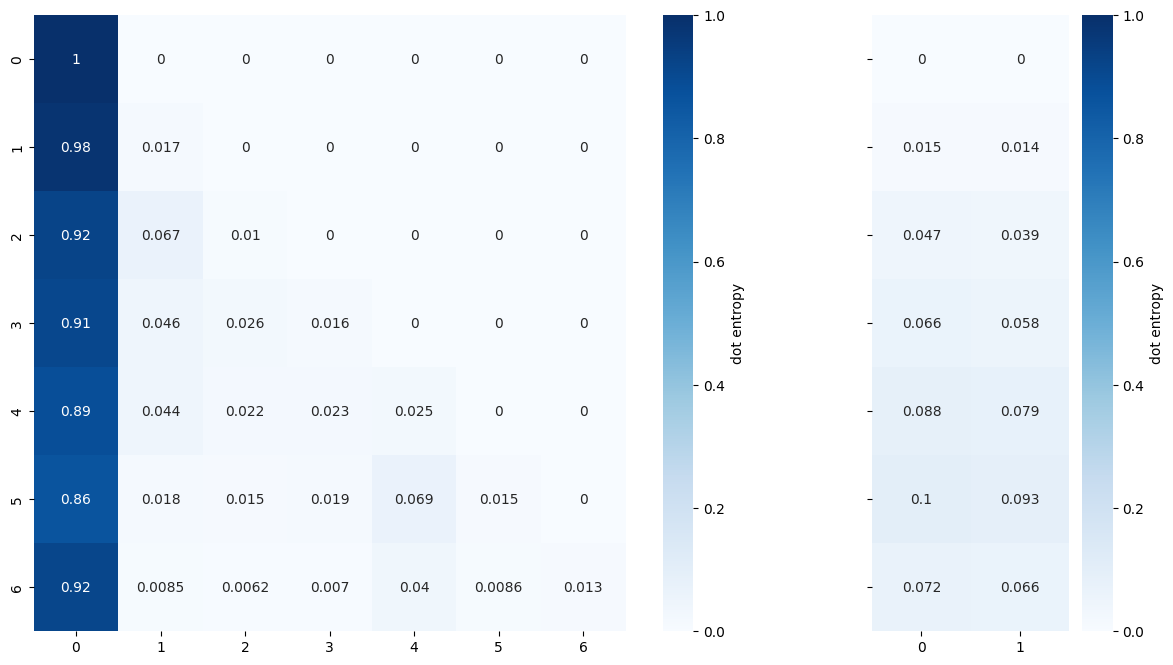

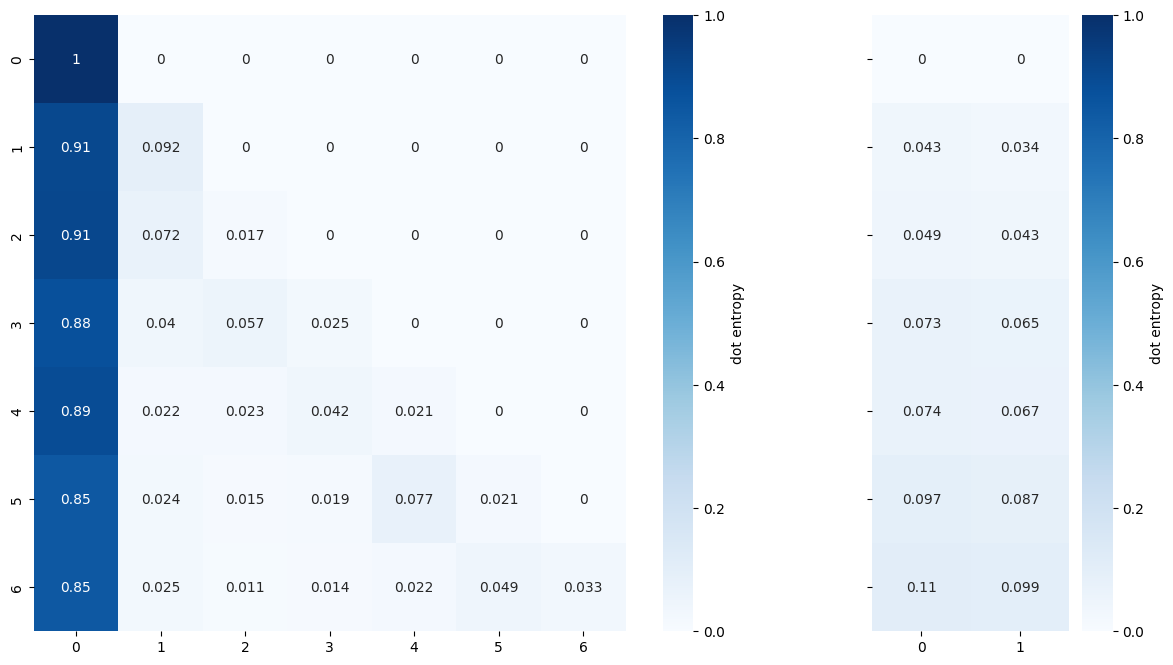

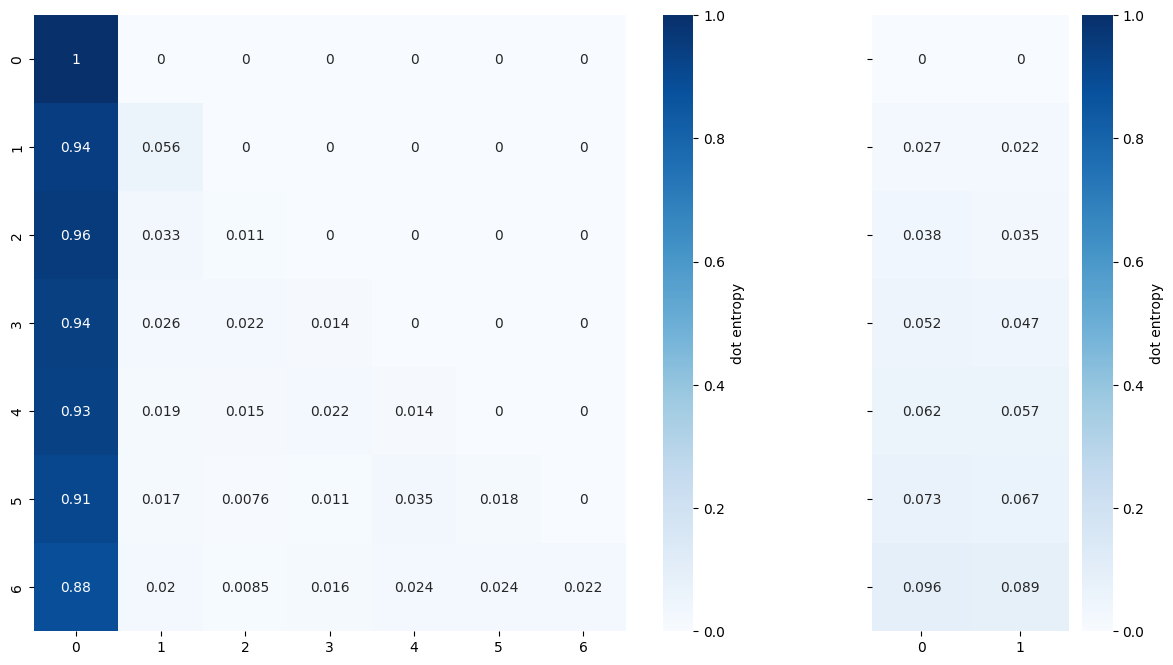

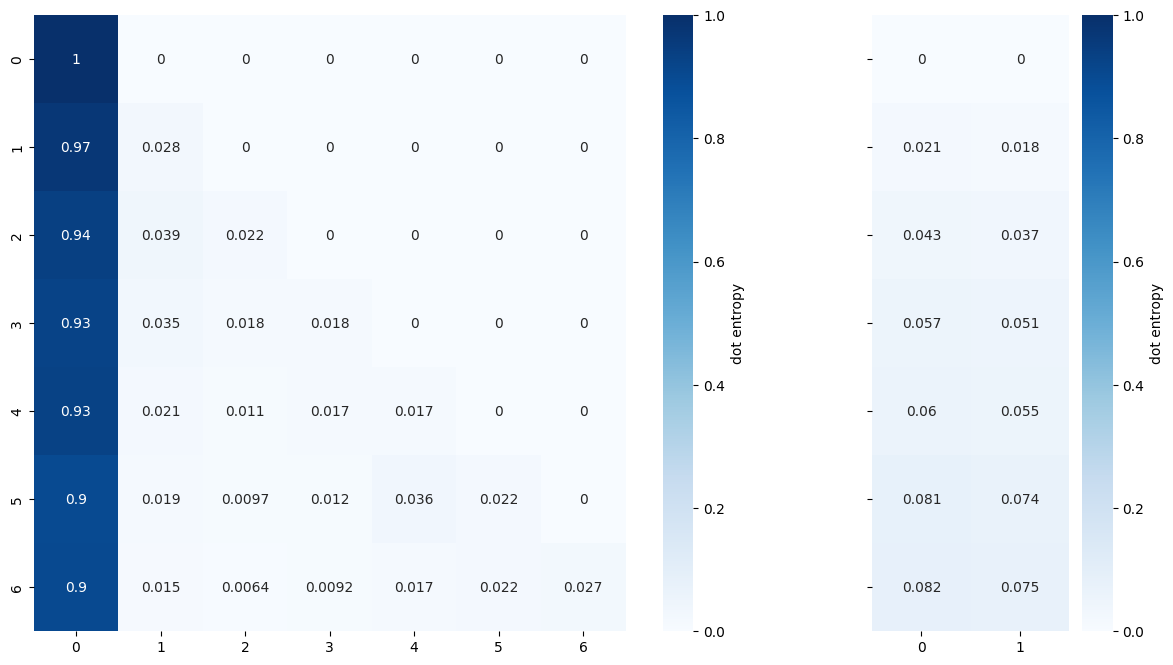

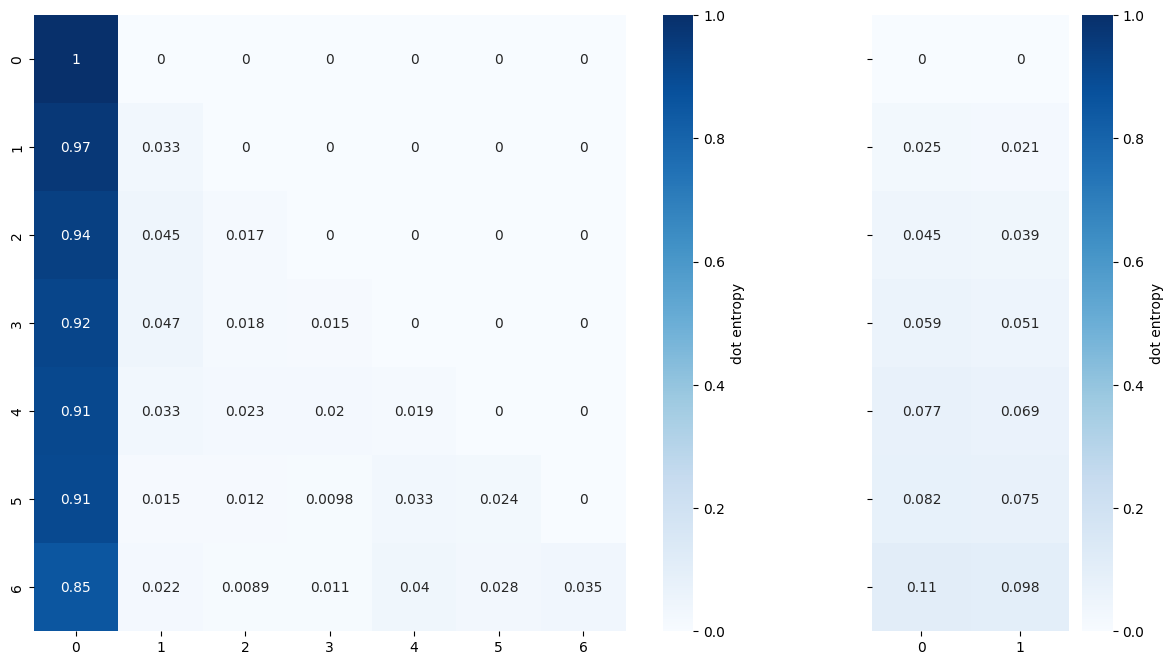

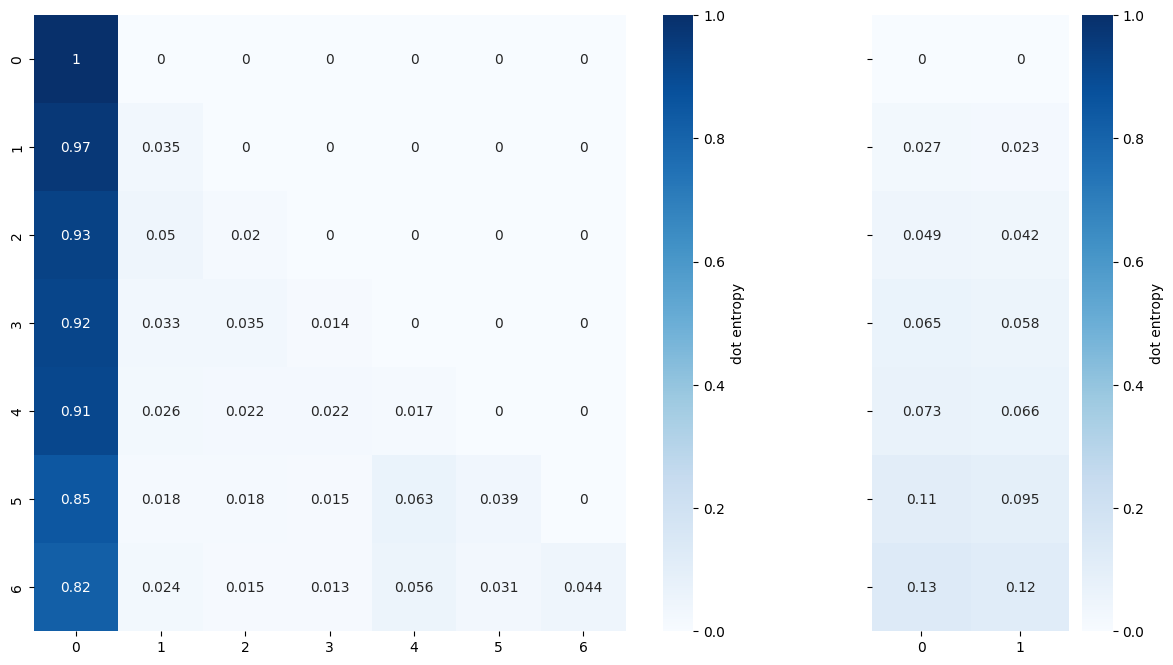

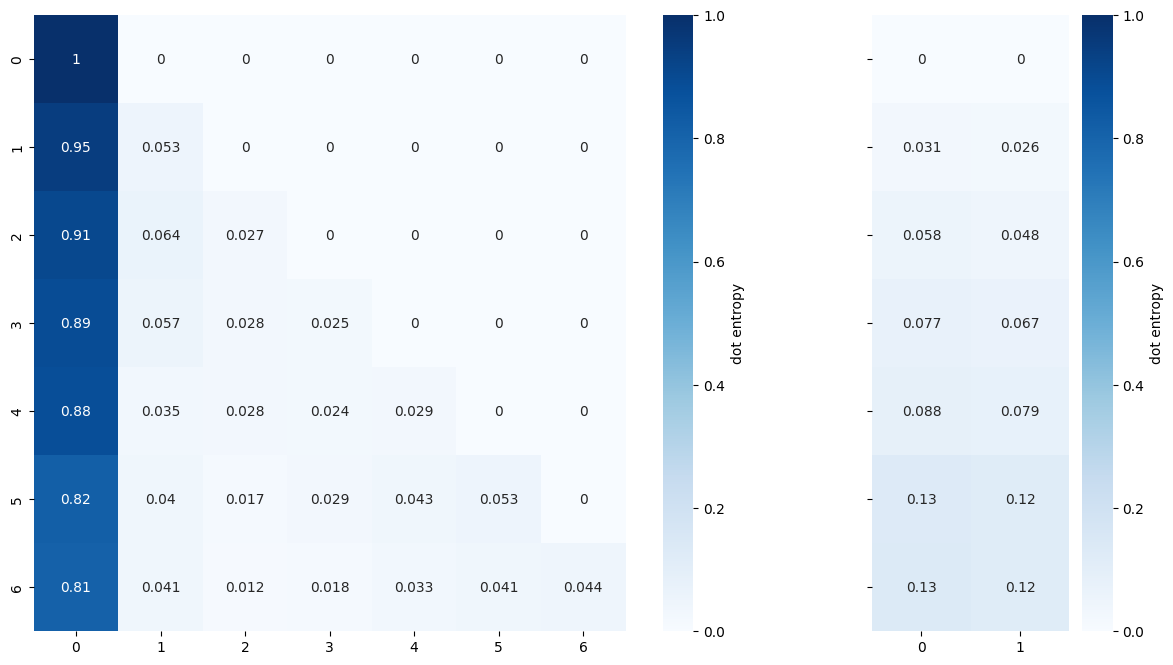

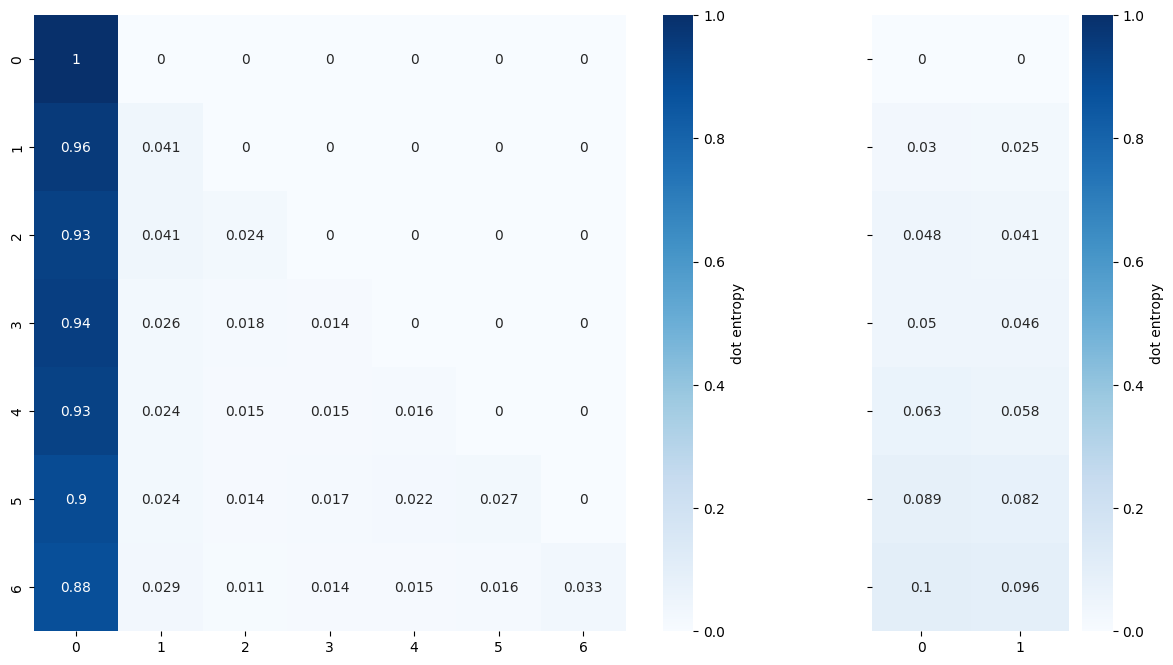

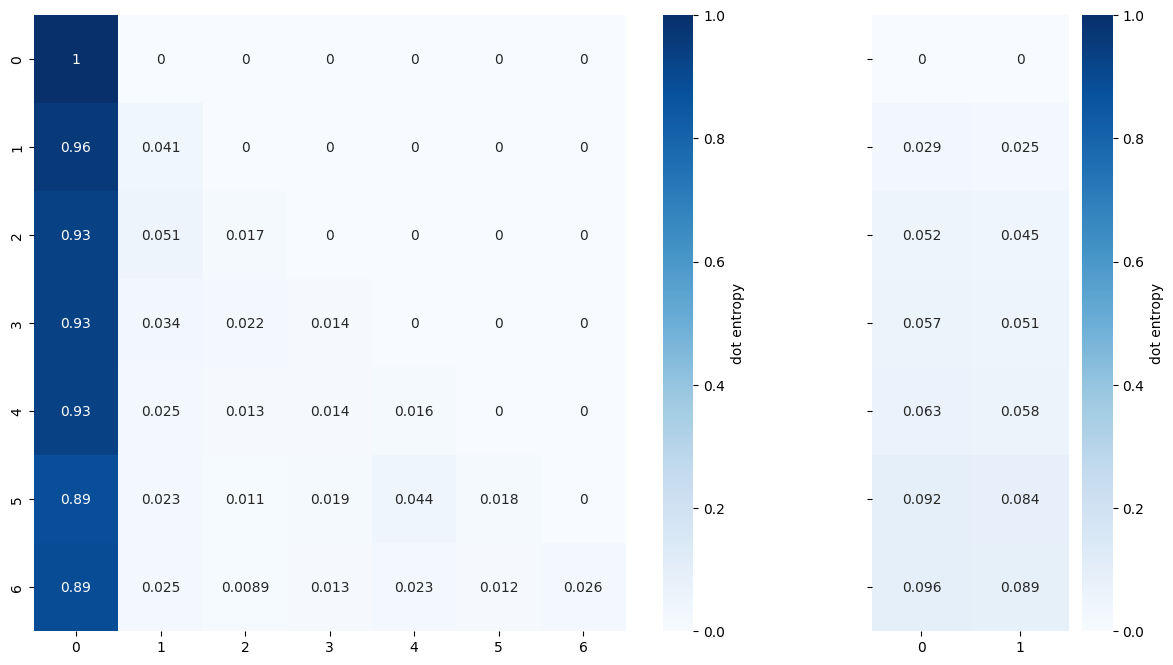

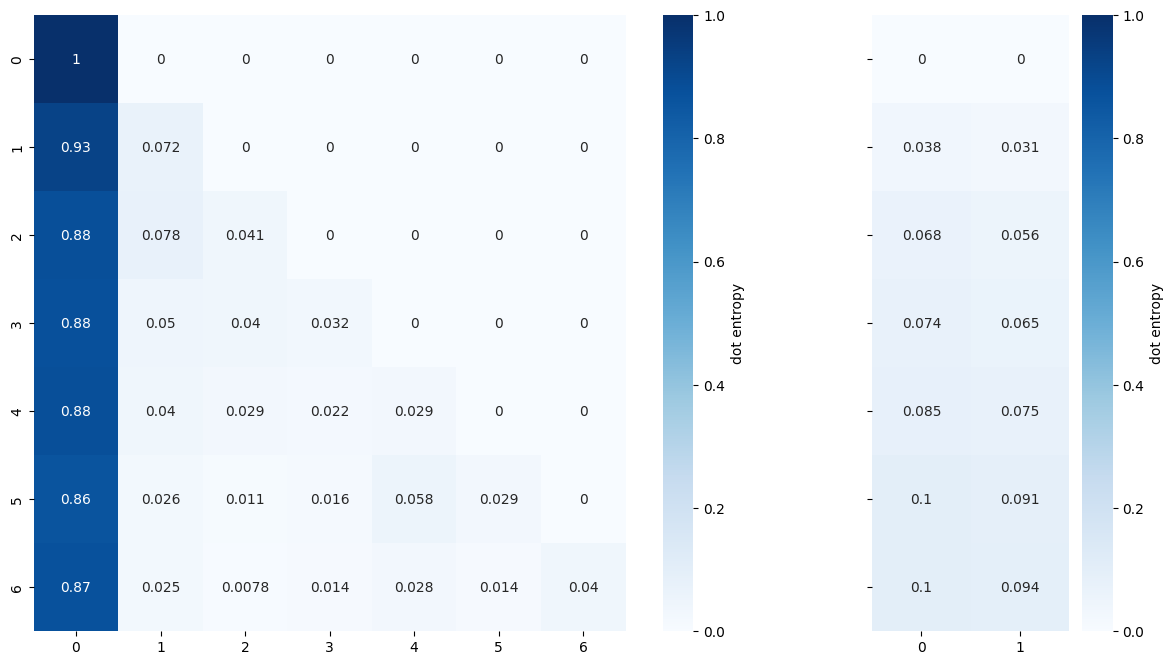

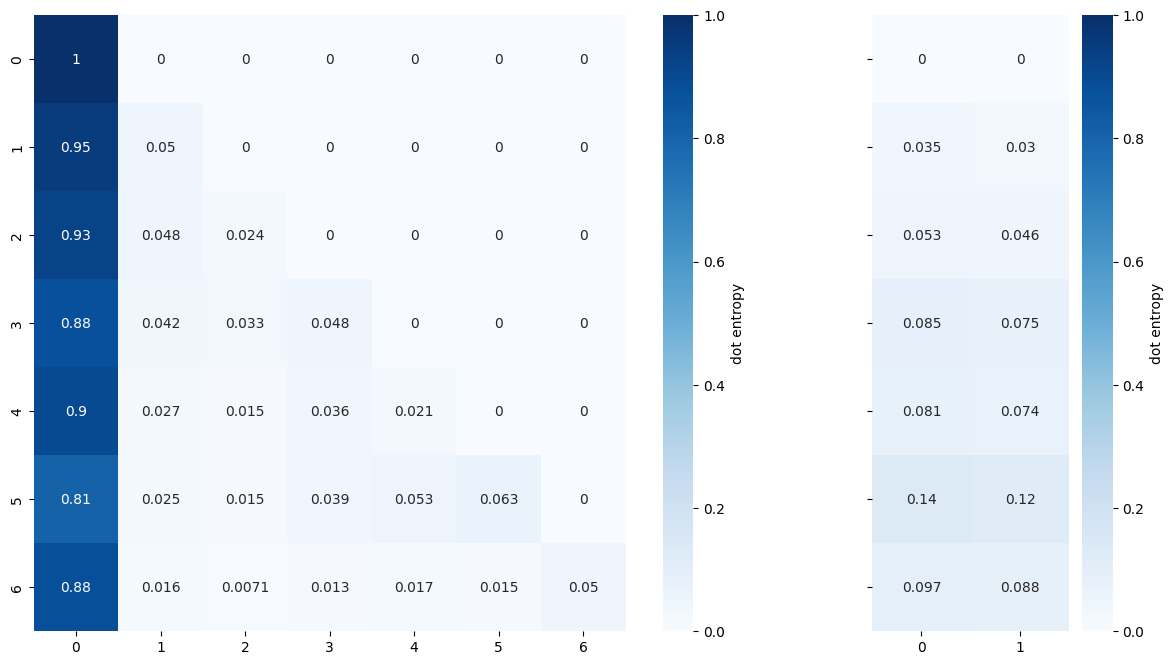

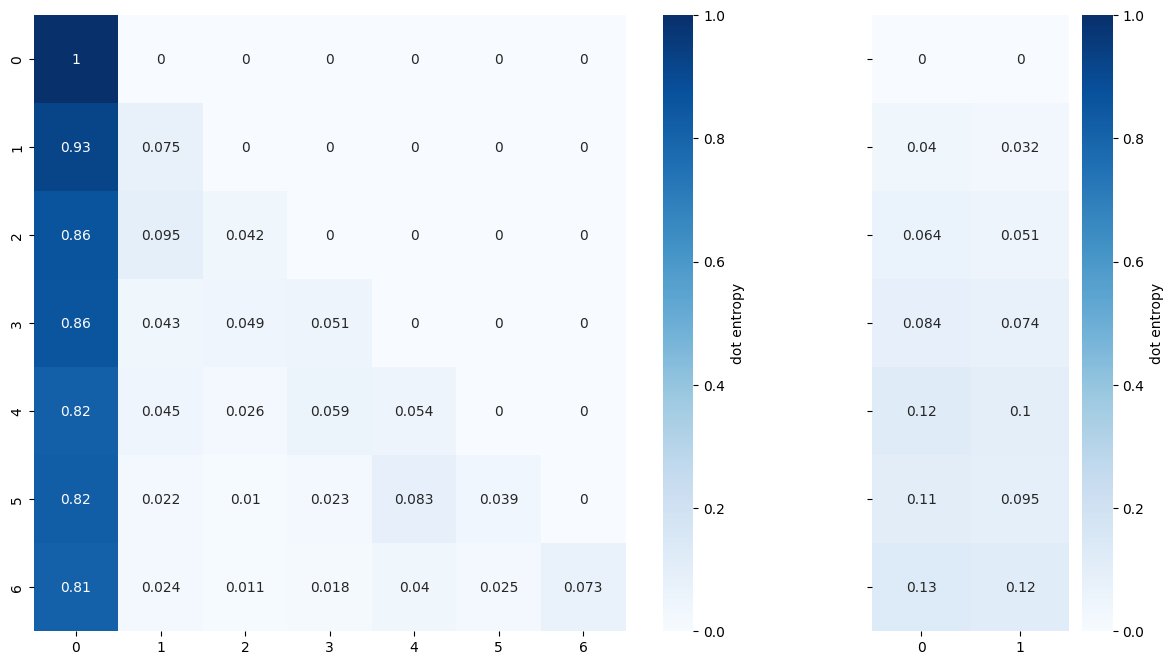

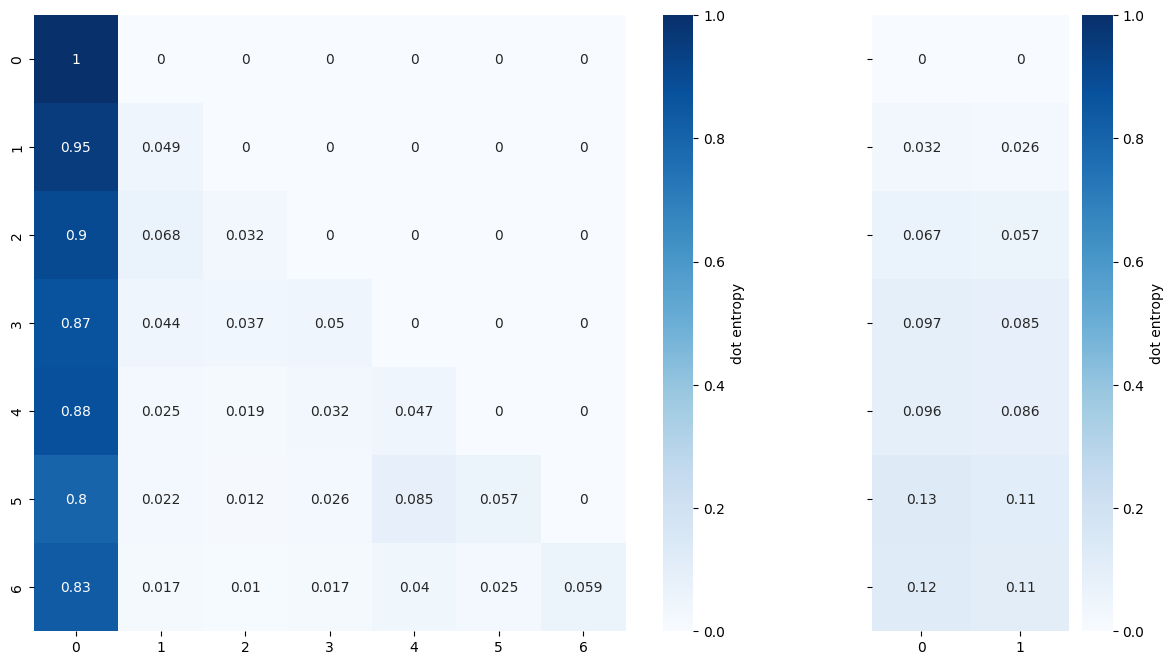

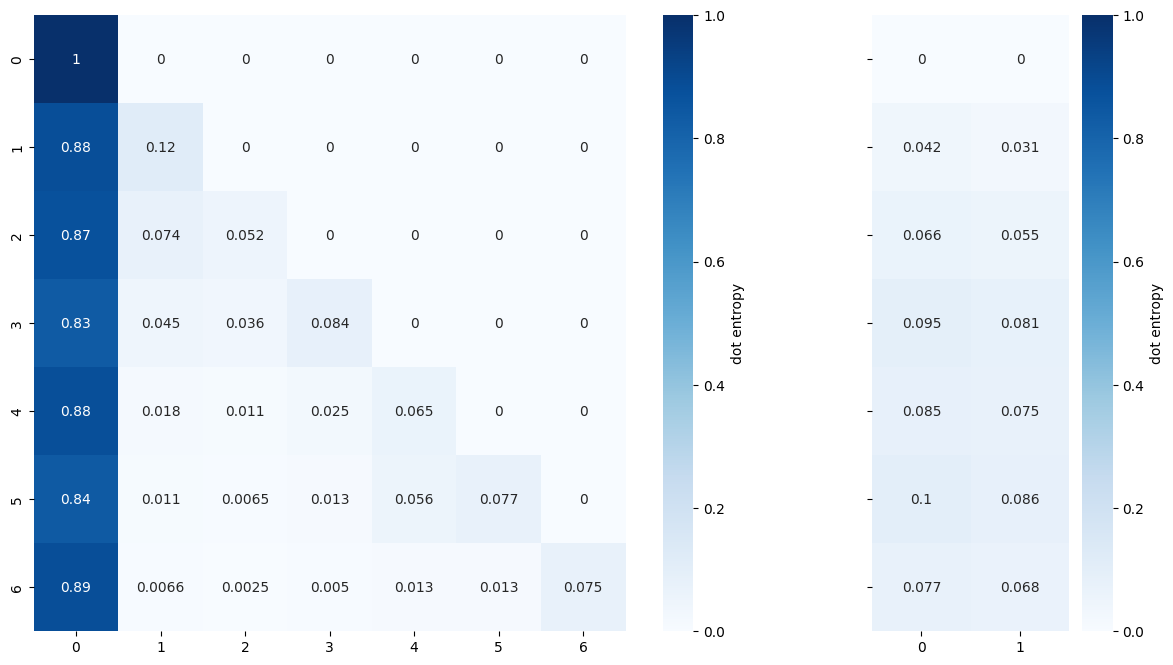

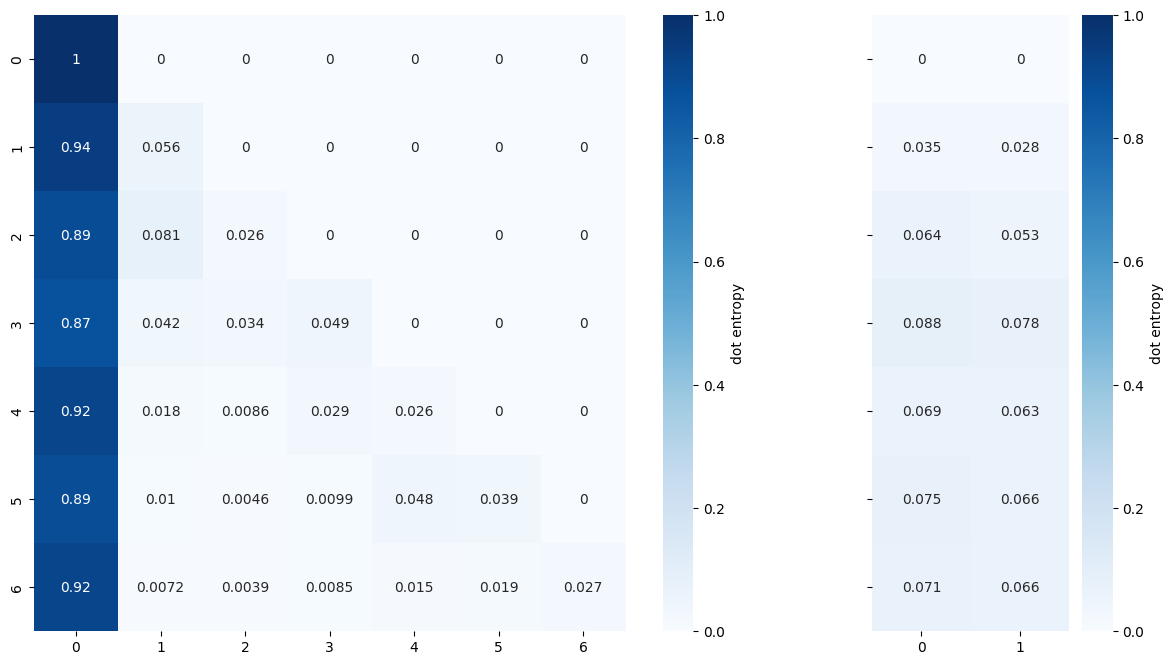

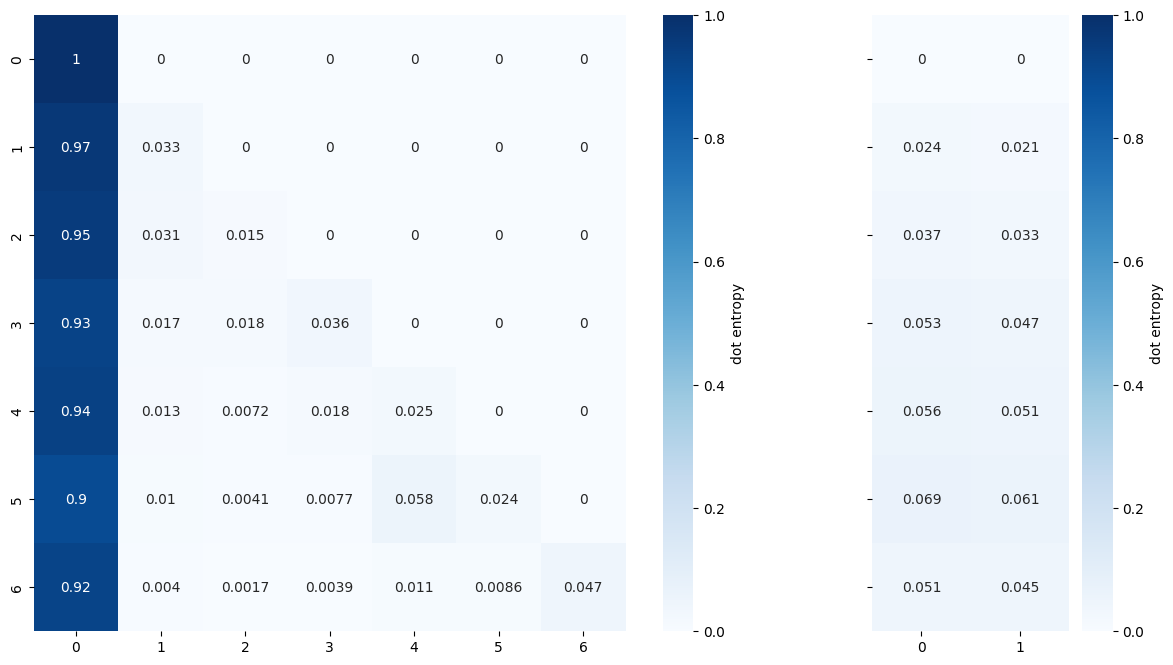

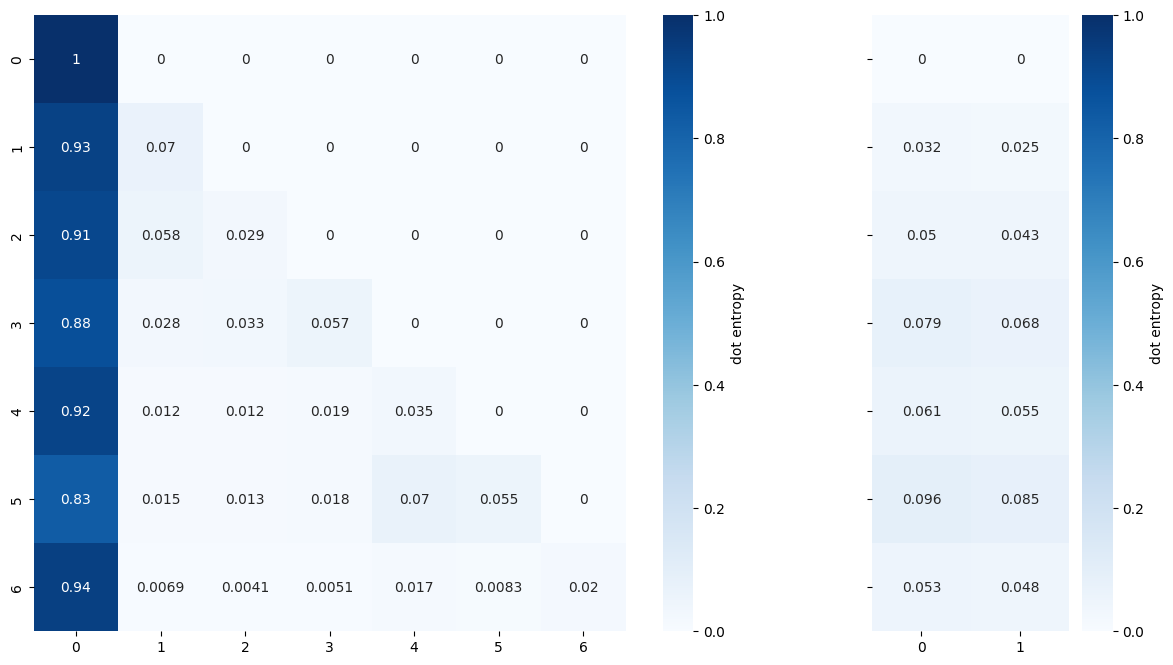

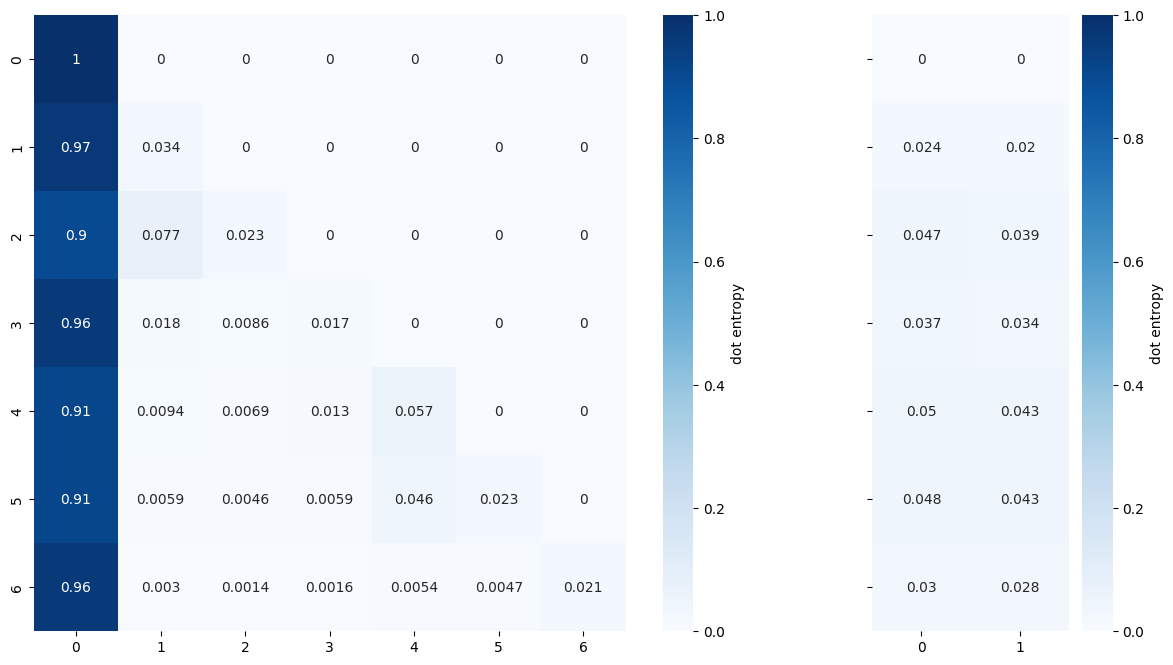

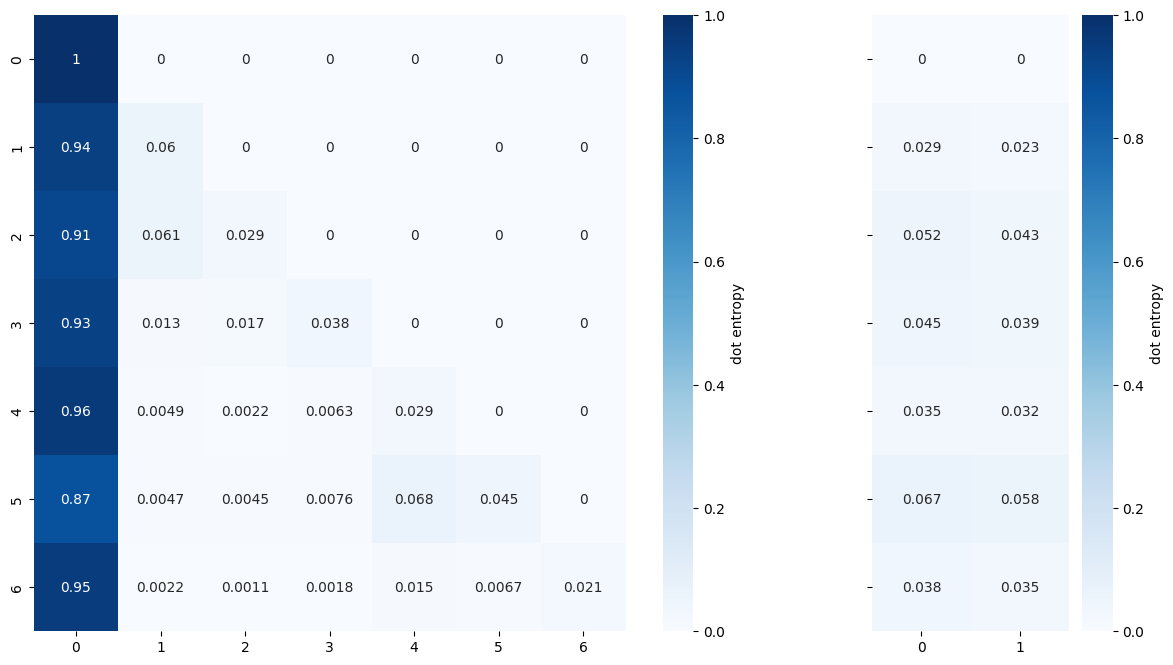

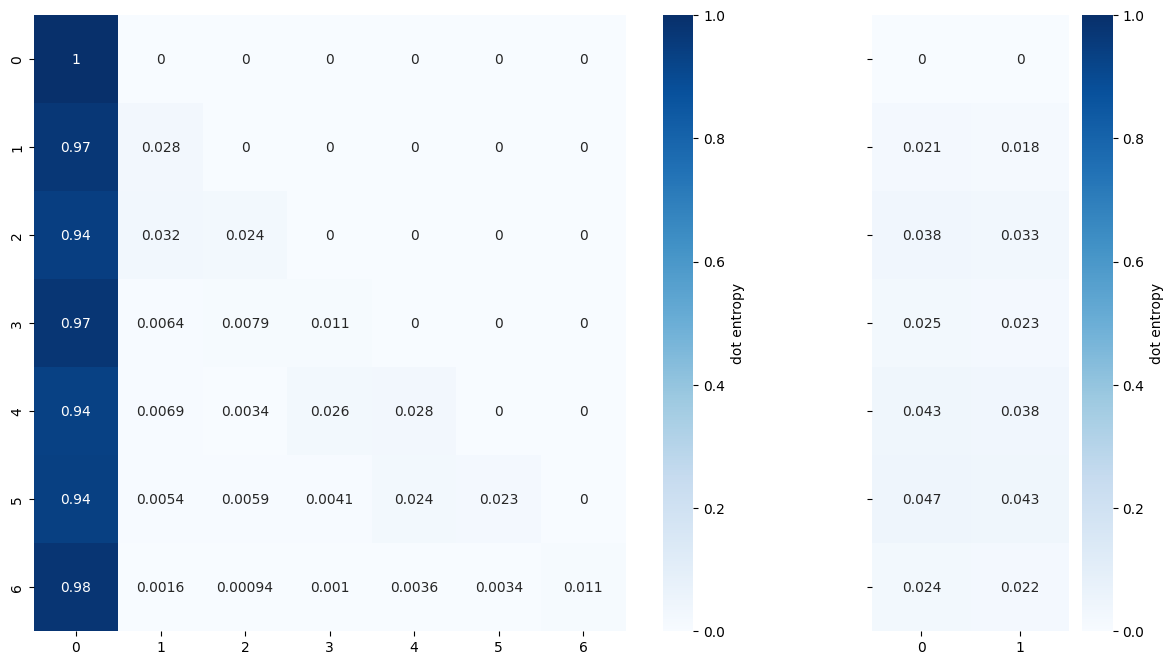

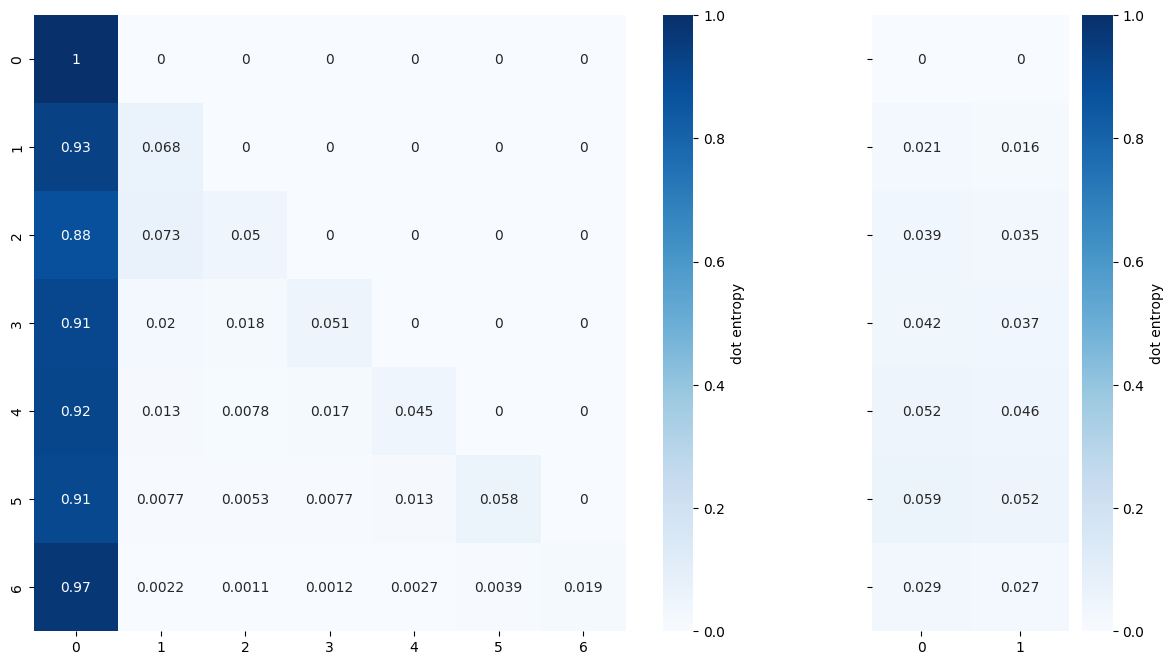

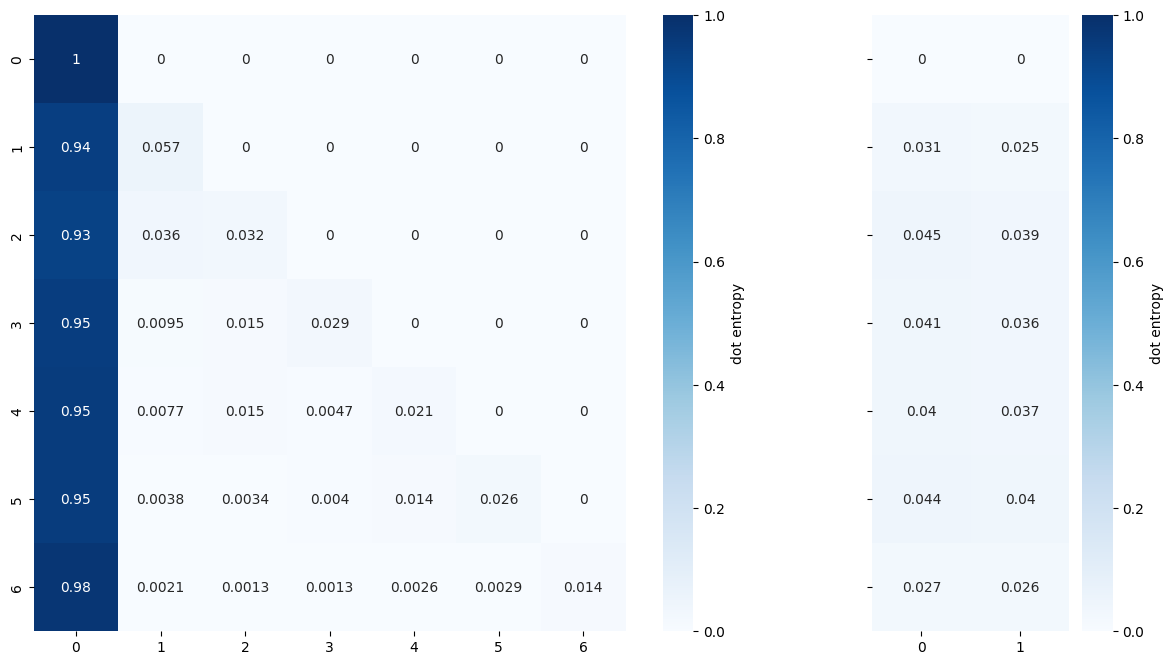

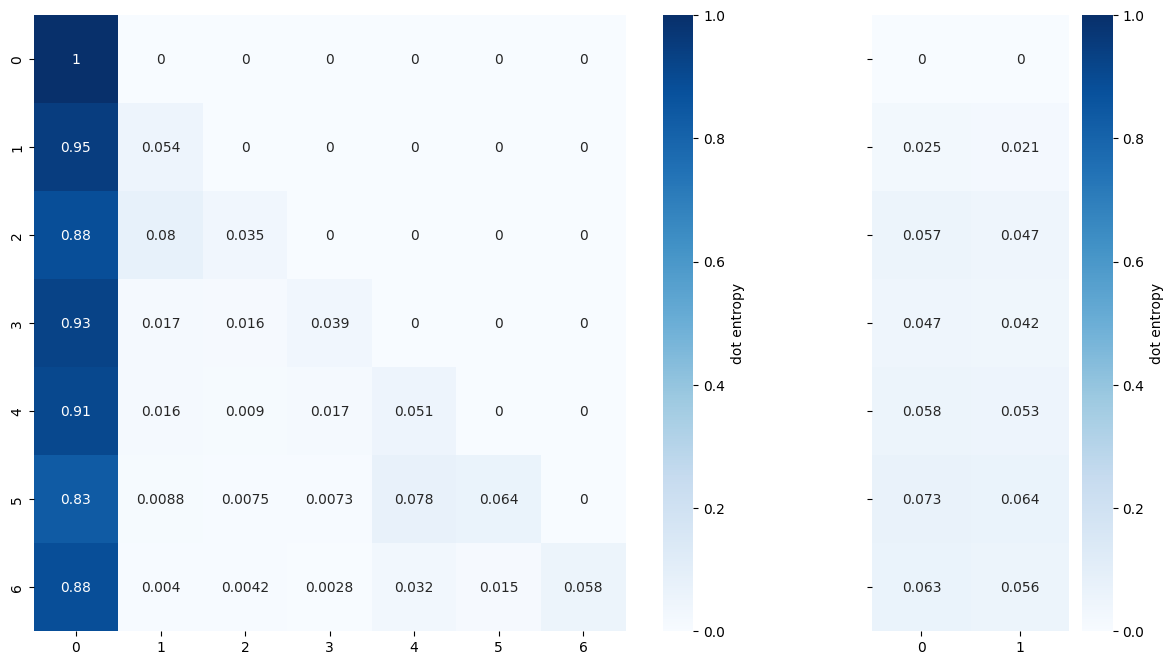

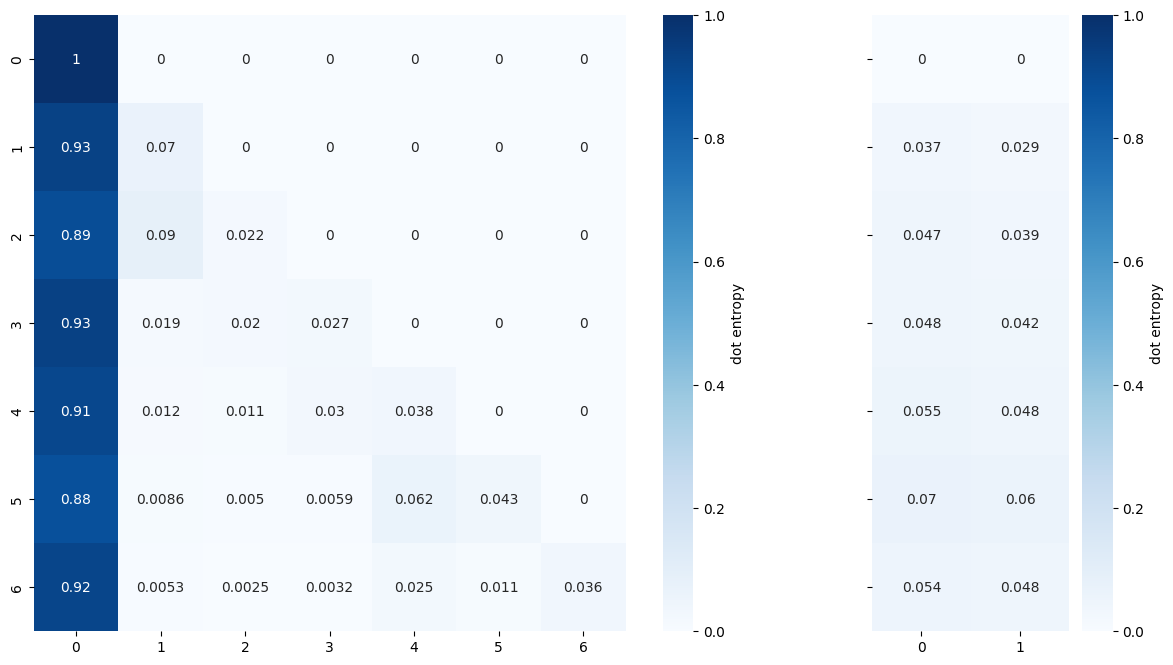

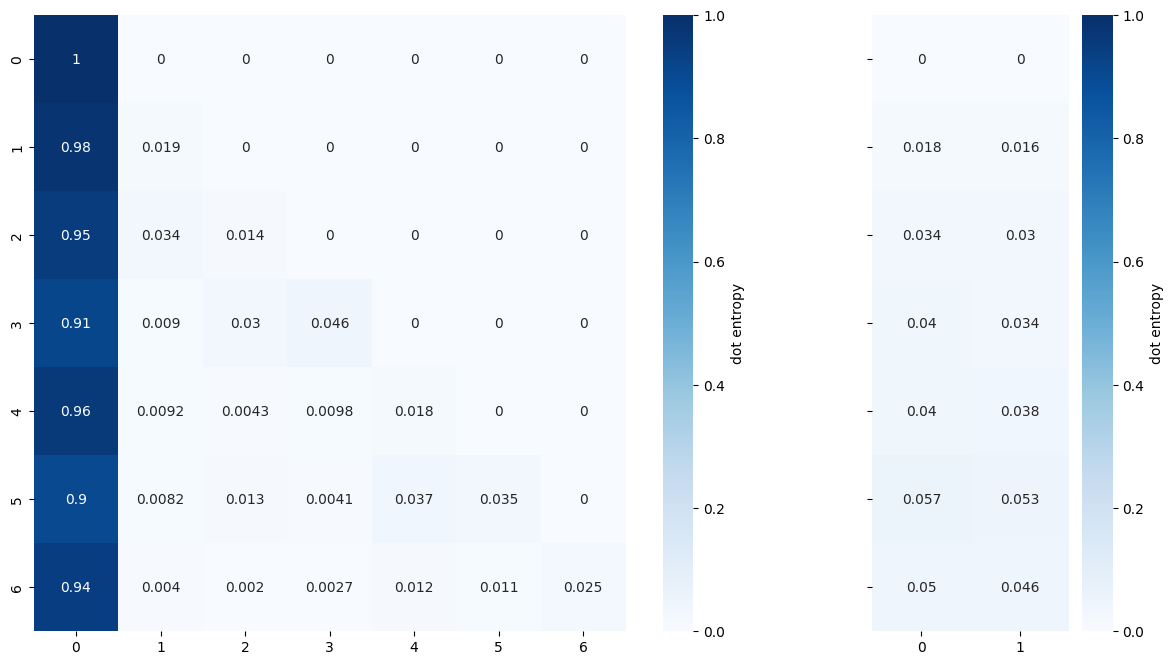

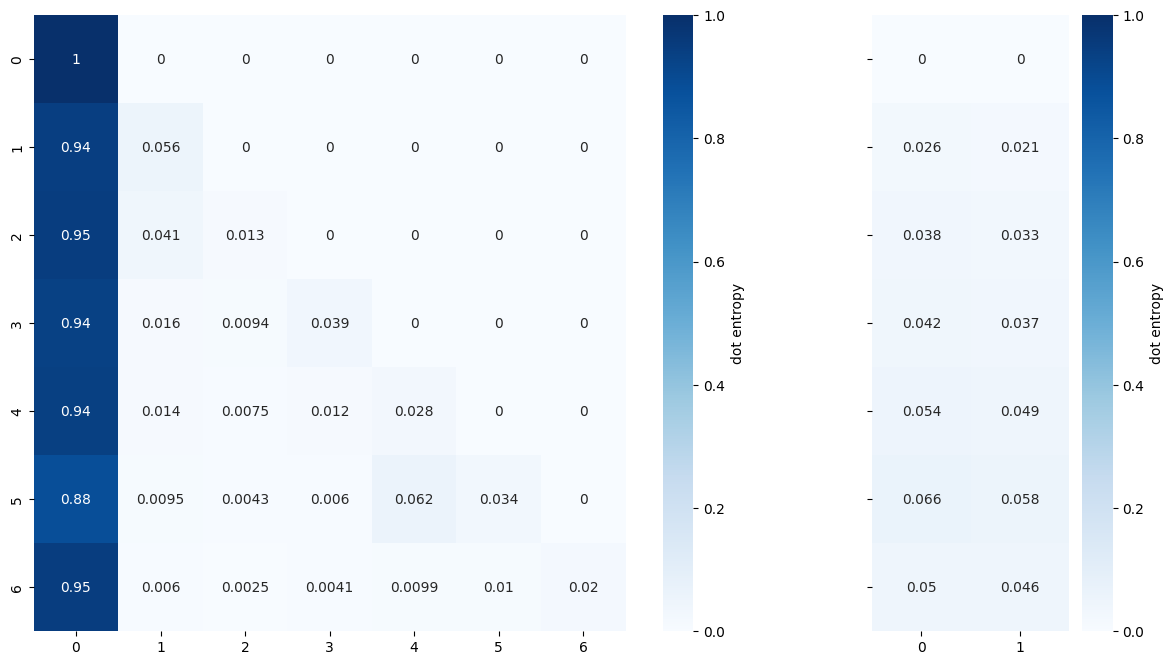

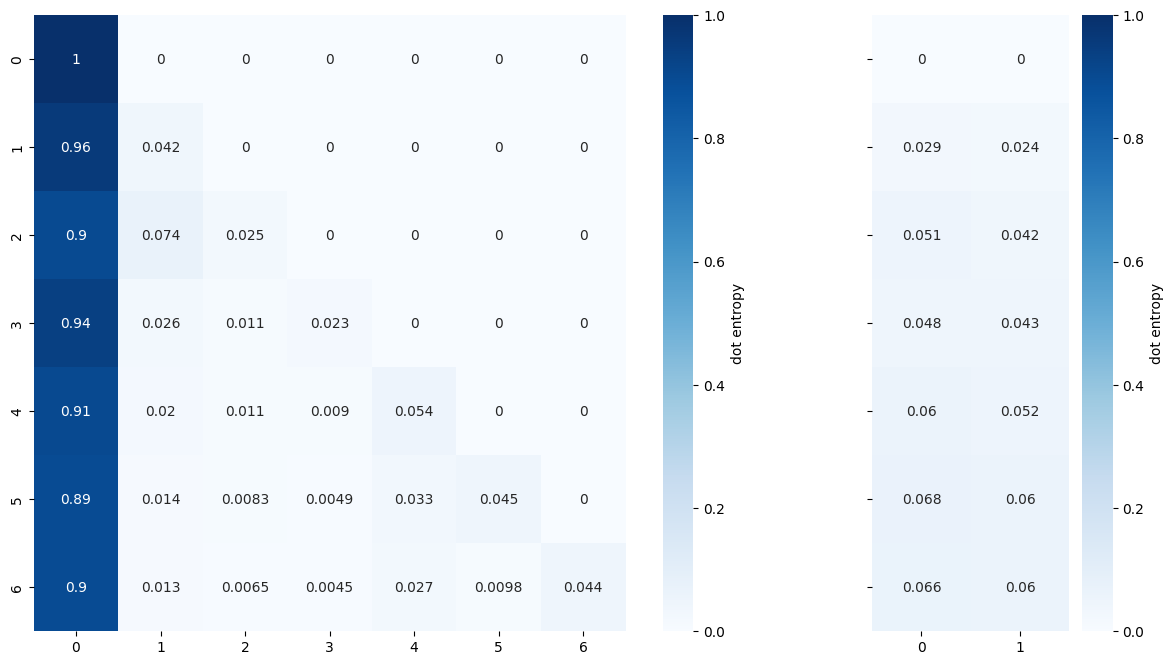

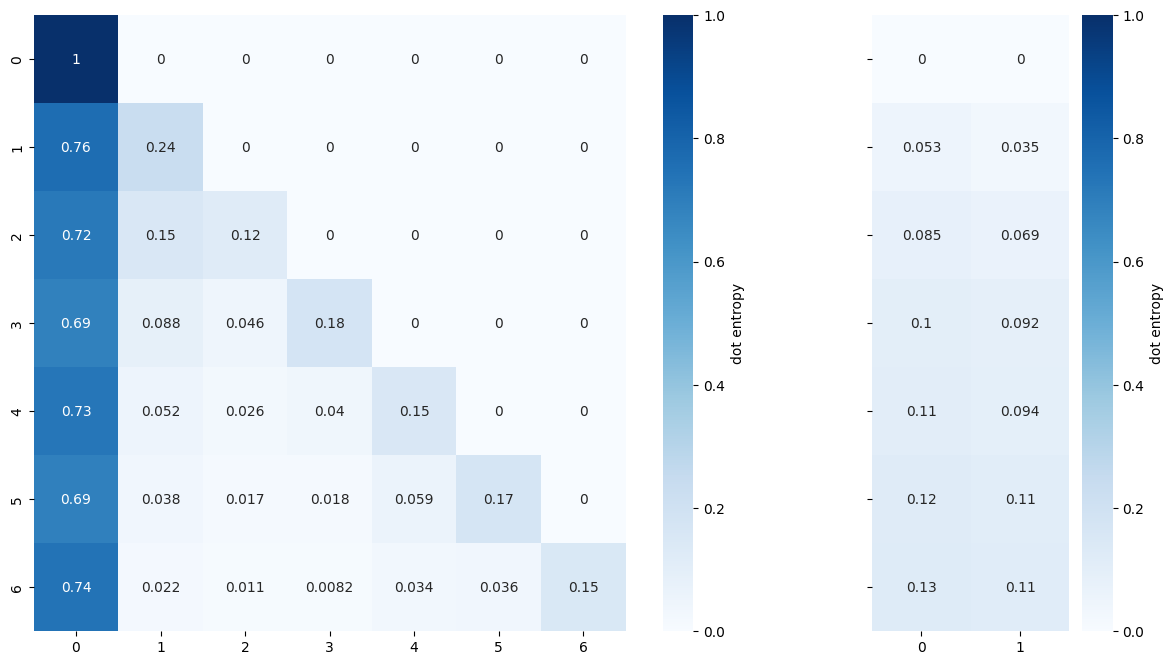

In [32]:
batch_index = 0
for layer_idx in range(len(generated_ids.attentions)):
    # (heads, seq_len, seq_len)
    attention_matrix = (
        generated_ids.attentions[layer_idx][batch_index].cpu().detach().numpy()
    )
    fig, (ax1, ax2) = plt.subplots(
        1,
        2,
        figsize=(len(predicted_tokens[0]) * 2, 8),
        gridspec_kw={"width_ratios": [3, 1]},
        sharey=True,
    )
    sns.heatmap(
        attention_matrix.mean(axis=0),
        annot=True,  # Set to True if you want to see values
        cmap="Blues",
        cbar_kws={"label": "dot entropy"},
        ax=ax1,
        vmin=0,
        vmax=1,
    )
    sns.heatmap(
        np.concatenate(
            (
                attention_entropy[layer_idx][:, np.newaxis],
                attention_entropy_bar[layer_idx][:, np.newaxis],
            ),
            axis=1,
        ),
        annot=True,  # Set to True if you want to see values
        cmap="Blues",
        cbar_kws={"label": "dot entropy"},
        ax=ax2,
        vmin=0,
        vmax=1,
    )

/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


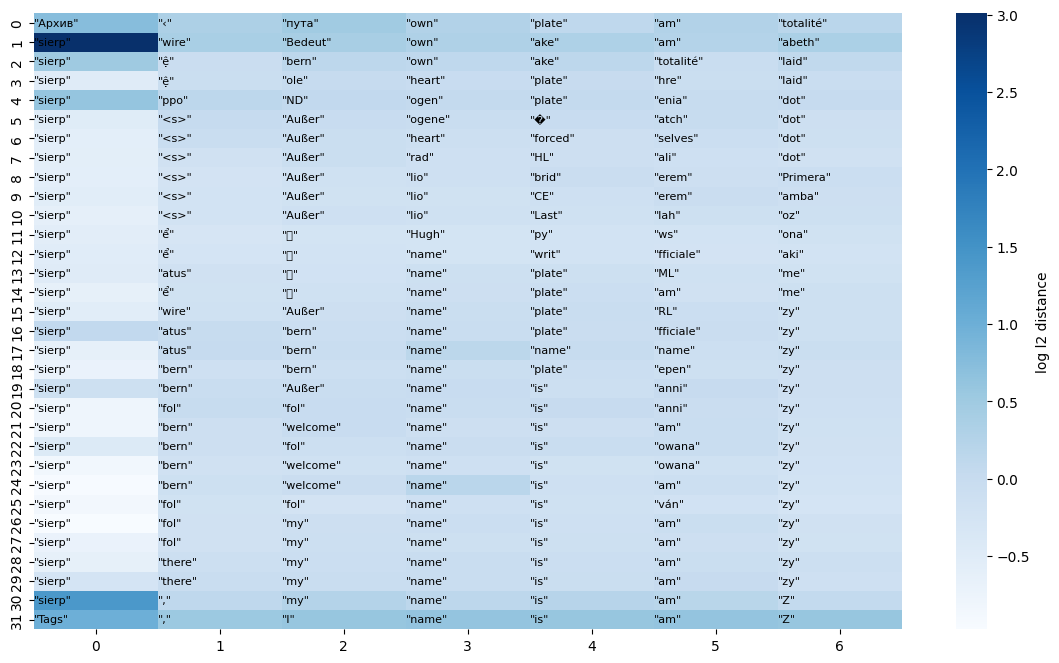

In [33]:
# L2 Distance
fig, (ax1) = plt.subplots(1, 1, figsize=(len(predicted_tokens[0])*2, 8))
sns.heatmap(np.log10(hidden_state_dis),
            annot=False,  # Set to True if you want to see values
            cmap='Blues',
            cbar_kws={'label': 'log l2 distance'},
            ax=ax1)

for i, tokens in enumerate(predicted_tokens):
    for j, token in enumerate(tokens):

        ax1.text(j, i+0.5, f'"{token}"', verticalalignment='center', fontsize=8)

/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


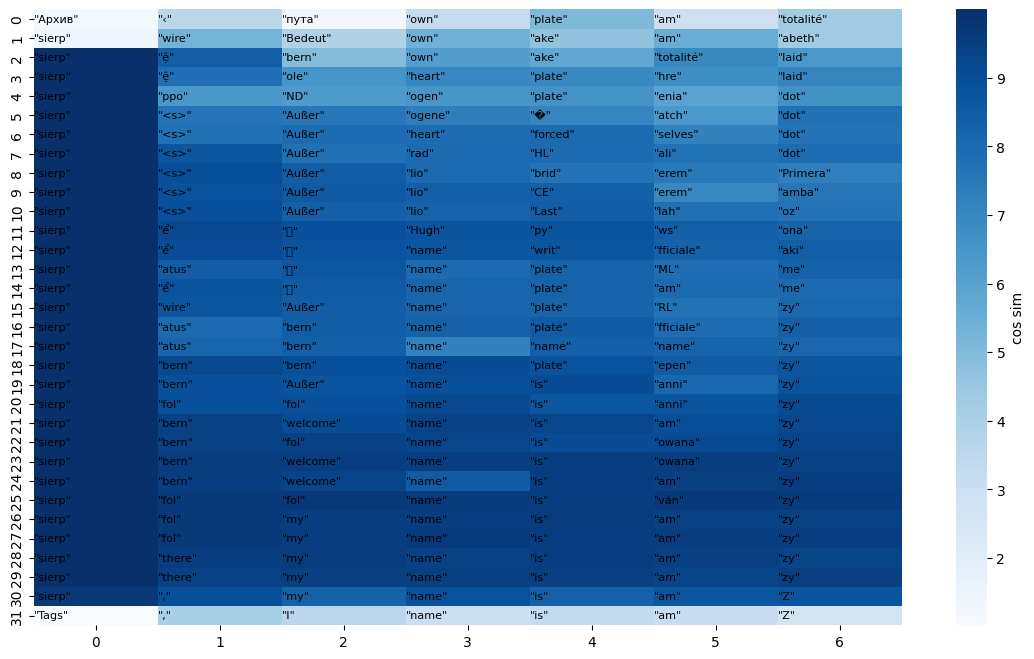

In [34]:
fig, (ax1) = plt.subplots(1, 1, figsize=(len(predicted_tokens[0])*2, 8))
sns.heatmap(np.pow(10,(hidden_state_cos)),
            annot=False,  # Set to True if you want to see values
            cmap='Blues',
            cbar_kws={'label': 'cos sim'},
            ax=ax1)

for i, tokens in enumerate(predicted_tokens):
    for j, token in enumerate(tokens):

        ax1.text(j, i+0.5, f'"{token}"', verticalalignment='center', fontsize=8)

/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


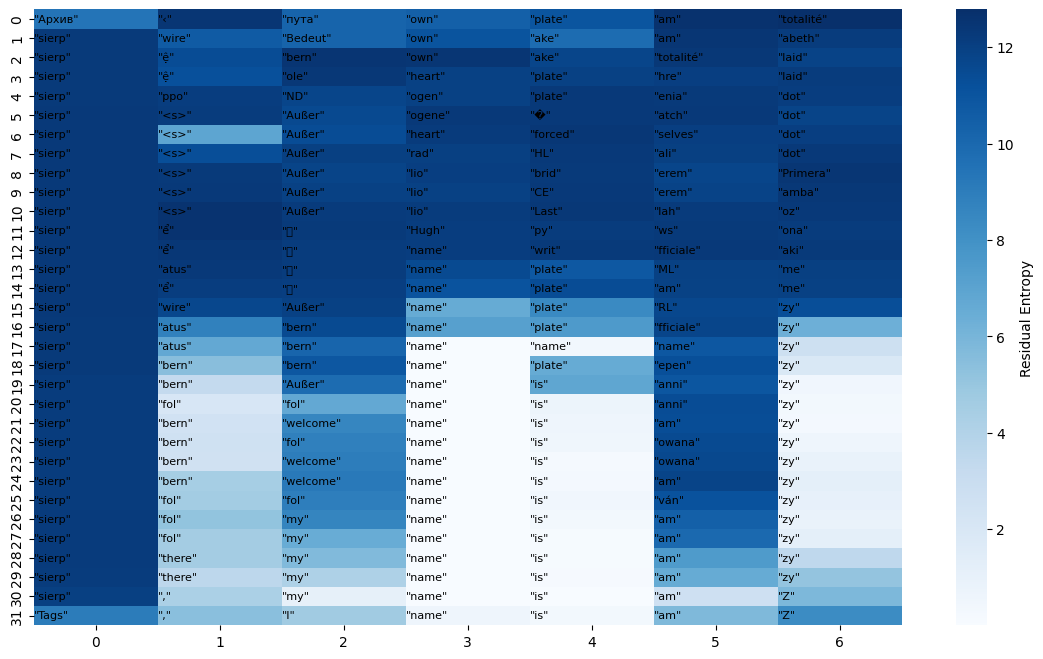

In [35]:
fig, (ax1) = plt.subplots(1, 1, figsize=(len(predicted_tokens[0])*2, 8))
sns.heatmap(logit_entropy_per_layer,
            annot=False,  # Set to True if you want to see values
            cmap='Blues',
            cbar_kws={'label': 'Residual Entropy'},
            ax=ax1)

for i, tokens in enumerate(predicted_tokens):
    for j, token in enumerate(tokens):
        ax1.text(j, i+0.5, f'"{token}"', verticalalignment='center', fontsize=8)

/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


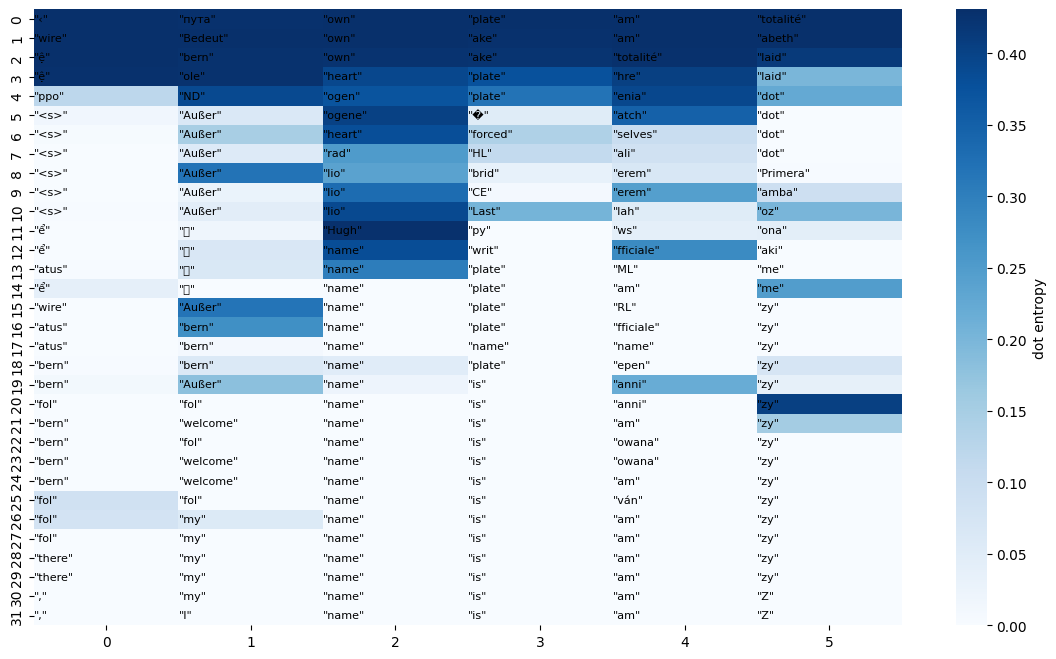

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(len(predicted_tokens[0])*2, 8))
sns.heatmap(proxy_attn_entropy,
            annot=False,  # Set to True if you want to see values
            cmap='Blues',
            cbar_kws={'label': 'dot entropy'},
            ax=ax1)

for i, tokens in enumerate(predicted_tokens):
    for j, token in enumerate(tokens[1:]):
        ax1.text(j, i+0.5, f'"{token}"', verticalalignment='center', fontsize=8)

/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


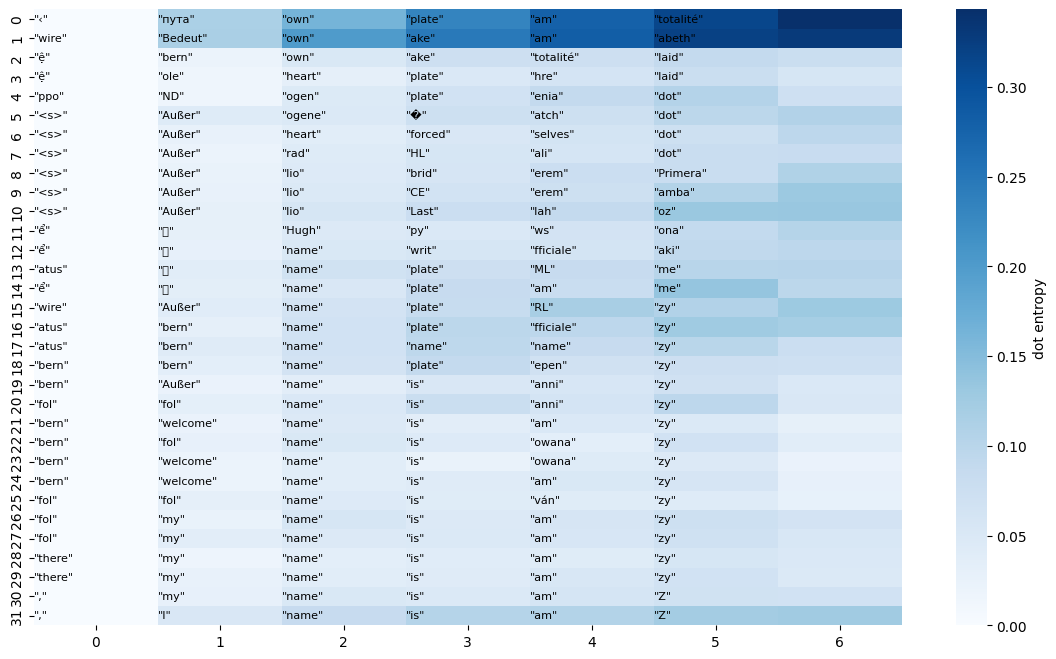

In [36]:
fig, (ax1) = plt.subplots(1, 1, figsize=(len(predicted_tokens[0])*2, 8))
sns.heatmap(attention_entropy,
            annot=False,  # Set to True if you want to see values
            cmap='Blues',
            cbar_kws={'label': 'dot entropy'},
            ax=ax1)

for i, tokens in enumerate(predicted_tokens):
    for j, token in enumerate(tokens[1:]):
        ax1.text(j, i+0.5, f'"{token}"', verticalalignment='center', fontsize=8)

IndexError: too many indices for tensor of dimension 0

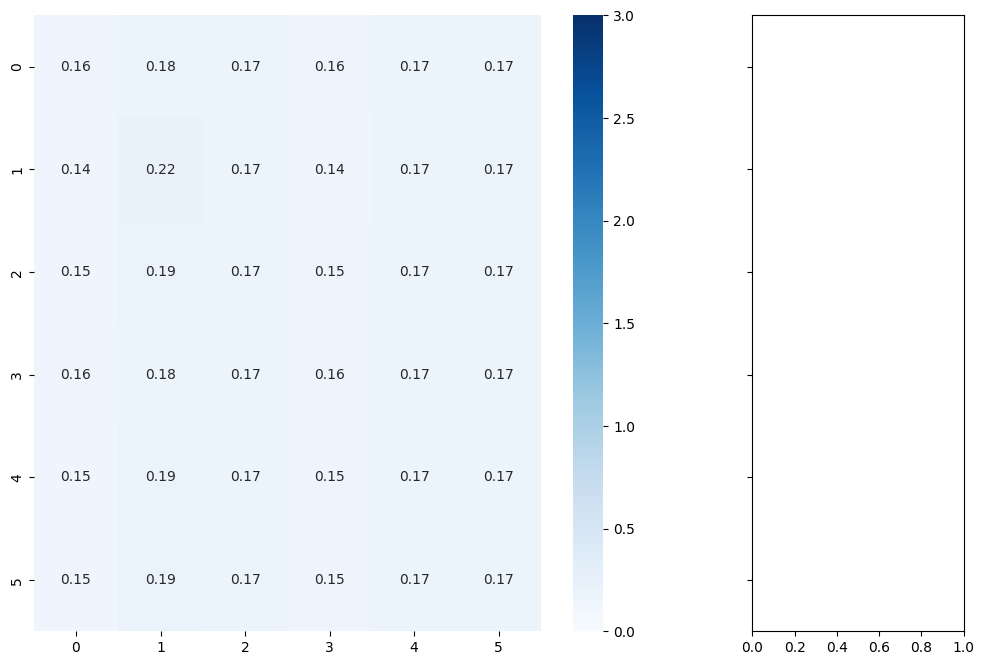

In [12]:
for i in range(32):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={"width_ratios": [3, 1]}, sharey=True)
    sns.heatmap(proxy_dot_prod[i,:,:], ax=ax1, cmap='Blues', annot=True, vmin=0, vmax=3)
    sns.heatmap(attention_entropy[i].mean(axis=0)[:, np.newaxis], ax=ax2, cmap='Blues', annot=True, vmin=0, vmax=3)
    plt.title(f"layer {i}")
    plt.show()


In [ ]:


batch_index = 0
for layer_idx in range(len(generated_ids.attentions)):
    # (heads, seq_len, seq_len)
    attention_matrix = (
        generated_ids.attentions[layer_idx][batch_index].cpu().detach().numpy()
    )
    fig, (ax1) = plt.subplots(1, 1, figsize=(len(predicted_tokens[0])*2, 8))
    sns.heatmap(attention_matrix.mean(axis=0),
            annot=False,  # Set to True if you want to see values
            cmap='Blues',
            cbar_kws={'label': 'dot entropy'},
            ax=ax1)